# ***Kaggle case***: The complete Pokémon dataset

| Name                       | NIU     |
| -------------------------- | ------- |
| Levon Kesoyan Galstyan     | 1668018 |

My Kaggle project will use the dataset from [The Complete Pokémon Dataset](https://www.kaggle.com/datasets/rounakbanik/pokemon/data), which includes data of all Pokémon from the first seven generations, totaling 800 Pokémon. This dataset contains various details, from names and Pokédex numbers to types, stats, and more. This provides a rich amount of data, with 41 columns (features) in total.

The goal is to predict whether a given Pokémon is legendary based on its characteristics. To achieve this, we will work with the dataset, split it into training and testing sets, handle any missing values, encode our data if needed, and much more.

#### Let's take an initial look at our dataset and examine which features we have:

| Variable          | Definition                                                | Key                                                 | Type       |
|-------------------|-----------------------------------------------------------|-----------------------------------------------------|------------|
| `name`            | The Pokémon's English name                                |                                                     | Categorical  |
| `japanese_name`   | The Pokémon's original Japanese name                      |                                                     | Categorical  |
| `pokedex_number`  | National Pokédex entry number                             |                                                     | Numeric    |
| `percentage_male` | Percentage of the species that are male                   | Blank if genderless                                 | Numeric    |
| `type1`           | Primary type                                              | e.g., Grass, Fire                                   | Categorical  |
| `type2`           | Secondary type                                            | e.g., Flying, Poison                                | Categorical  |
| `classification`  | Classification in the Sun and Moon Pokédex                |                                                     | Categorical  |
| `height_m`        | Height in meters                                          |                                                     | Numeric    |
| `weight_kg`       | Weight in kilograms                                       |                                                     | Numeric    |
| `capture_rate`    | Capture rate                                              |                                                     | Numeric    |
| `base_egg_steps`  | Steps to hatch                                            |                                                     | Numeric    |
| `abilities`       | List of abilities                                         |                                                     | Categorical  |
| `experience_growth` | Experience growth rate                                  |                                                     | Numeric    |
| `base_happiness`  | Base happiness                                            |                                                     | Numeric    |
| `against_?`       | Damage taken from each type (18 columns)                  | e.g., against_fire, against_water                   | Numeric    |
| `hp`              | Base HP                                                   |                                                     | Numeric    |
| `attack`          | Base attack                                               |                                                     | Numeric    |
| `defense`         | Base defense                                              |                                                     | Numeric    |
| `sp_attack`       | Base special attack                                       |                                                     | Numeric    |
| `sp_defense`      | Base special defense                                      |                                                     | Numeric    |
| `speed`           | Base speed                                                |                                                     | Numeric    |
| `generation`      | Generation introduced                                     | Values from 1 to 7                                  | Numeric    |
| `is_legendary`    | Whether the Pokémon is legendary                          | 1 = Legendary, 0 = Not Legendary                    | Binary     |


As we can see, we have many different variables, including categorical, numeric and binary variables.

Before starting with the code, we will need to import the necessary libraries:

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.cm import gist_heat_r
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import *
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

plt.rcParams['figure.dpi'] = 80

Next, we will load our dataset to start with the analysis:

In [105]:
df = pd.read_csv('pokemon.csv')

To begin with, let's see which variables have missing values (NaN).

In [106]:
percent_nan_col = df.isna().mean(axis = 0).sort_values(ascending = False)
percent_nan_col

type2             0.4794
percentage_male   0.1223
weight_kg         0.0250
height_m          0.0250
name              0.0000
                   ...  
against_psychic   0.0000
against_rock      0.0000
against_steel     0.0000
against_water     0.0000
is_legendary      0.0000
Length: 41, dtype: float64

In [107]:
def showNaNColumn(column):
    return df[df[[column]].isna().any(axis=1)]['name']

In [108]:
pokemon_with_nan = showNaNColumn('weight_kg')
print(pokemon_with_nan)


18       Rattata
19      Raticate
25        Raichu
26     Sandshrew
27     Sandslash
36        Vulpix
37     Ninetales
49       Diglett
50       Dugtrio
51        Meowth
52       Persian
73       Geodude
74      Graveler
75         Golem
87        Grimer
88           Muk
102    Exeggutor
104      Marowak
719        Hoopa
744     Lycanroc
Name: name, dtype: object


In [109]:
pokemon_with_nan = showNaNColumn('height_m')
print(pokemon_with_nan)

18       Rattata
19      Raticate
25        Raichu
26     Sandshrew
27     Sandslash
36        Vulpix
37     Ninetales
49       Diglett
50       Dugtrio
51        Meowth
52       Persian
73       Geodude
74      Graveler
75         Golem
87        Grimer
88           Muk
102    Exeggutor
104      Marowak
719        Hoopa
744     Lycanroc
Name: name, dtype: object


As we can see, the NaNs in these two columns come from the same Pokémons. This means that these 20 Pokémon have missing data, and we should handle these missing values.

In [110]:
pokemon_without_gender = showNaNColumn('percentage_male')
print(pokemon_without_gender)


80      Magnemite
81       Magneton
99        Voltorb
100     Electrode
119        Staryu
          ...    
796    Celesteela
797       Kartana
798      Guzzlord
799      Necrozma
800      Magearna
Name: name, Length: 98, dtype: object


We have NaNs in the columns 'type2', 'percentage_male', 'weight_kg' and 'height_m'. To solve this problem, we will do the following:

- The NaNs that are in the 'type2' column mean that the Pokémon only has 1 type. To avoid these NaNs, we will find all the NaNs in this column and replace it with 'None'.
- The NaNs that are in the 'percentage_male' column mean that the Pokémon is genderless. To avoid these NaNs, we will add a binary column called 'has_gender' and replace all the NaNs in the 'percentage male' column with 0. If this new column is False, then we will not look into the 'percentage_male' column.
- The NaNs that are in the 'weight_kg' and 'height_m' seem to be just missing values. To solve this problem, we will drop those rows, as the percentage is very low (0.0125) and it shouldn't affect our model. We won't fill these NaNs with, for example, the median of the variable, because in Pokémon the height and the weight are very variable. It will affect less our model if we just remove these samples.

In [ ]:
df['type2'] = df['type2'].fillna('None')

df['has_gender'] = df['percentage_male'].notna()

df['percentage_male'] = df['percentage_male'].fillna(0)

df.dropna(inplace=True, subset=['weight_kg', 'height_m'])

percent_nan_col = df.isna().mean(axis = 0).sort_values(ascending = False)
percent_nan_col

abilities         0.0000
percentage_male   0.0000
capture_rate      0.0000
classfication     0.0000
defense           0.0000
                   ...  
against_psychic   0.0000
against_rock      0.0000
against_steel     0.0000
against_water     0.0000
has_gender        0.0000
Length: 42, dtype: float64

Now that we have fixed our NaNs, we can search for correlations between our variables.

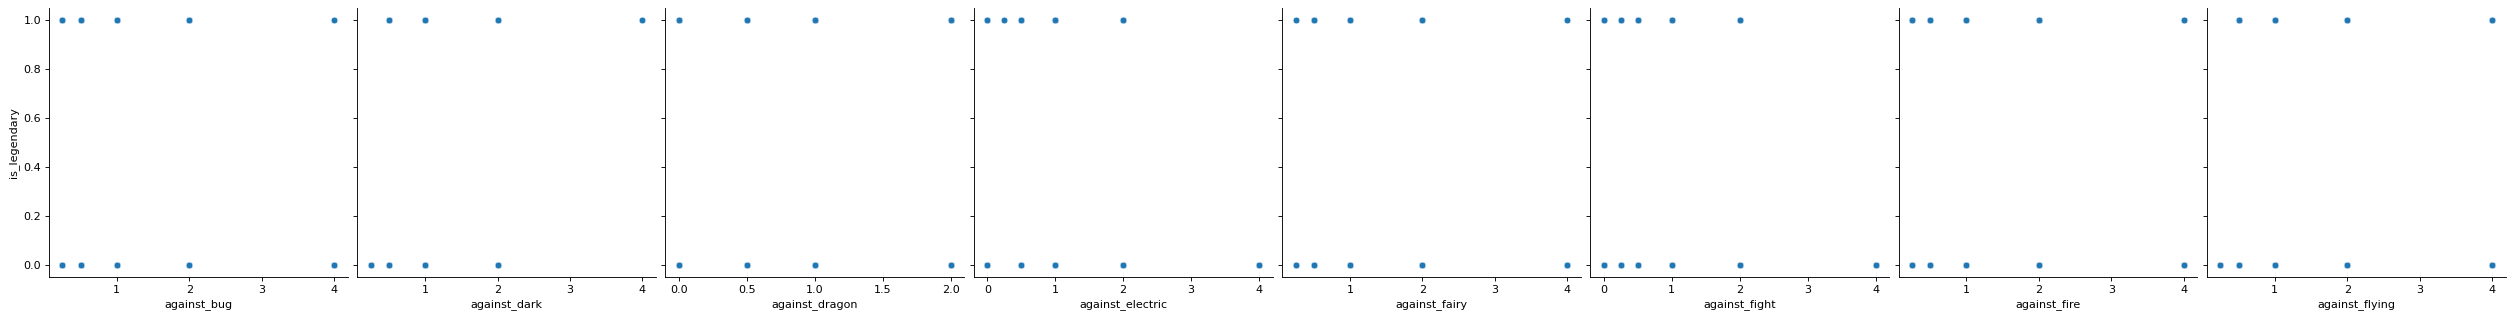

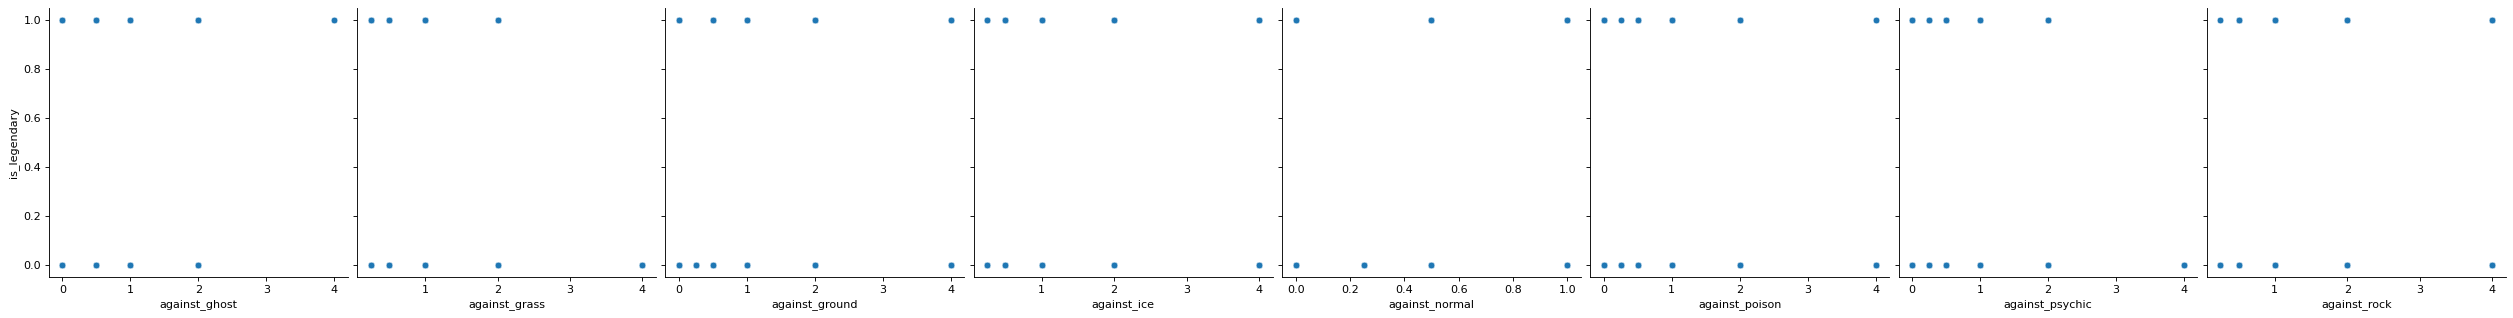

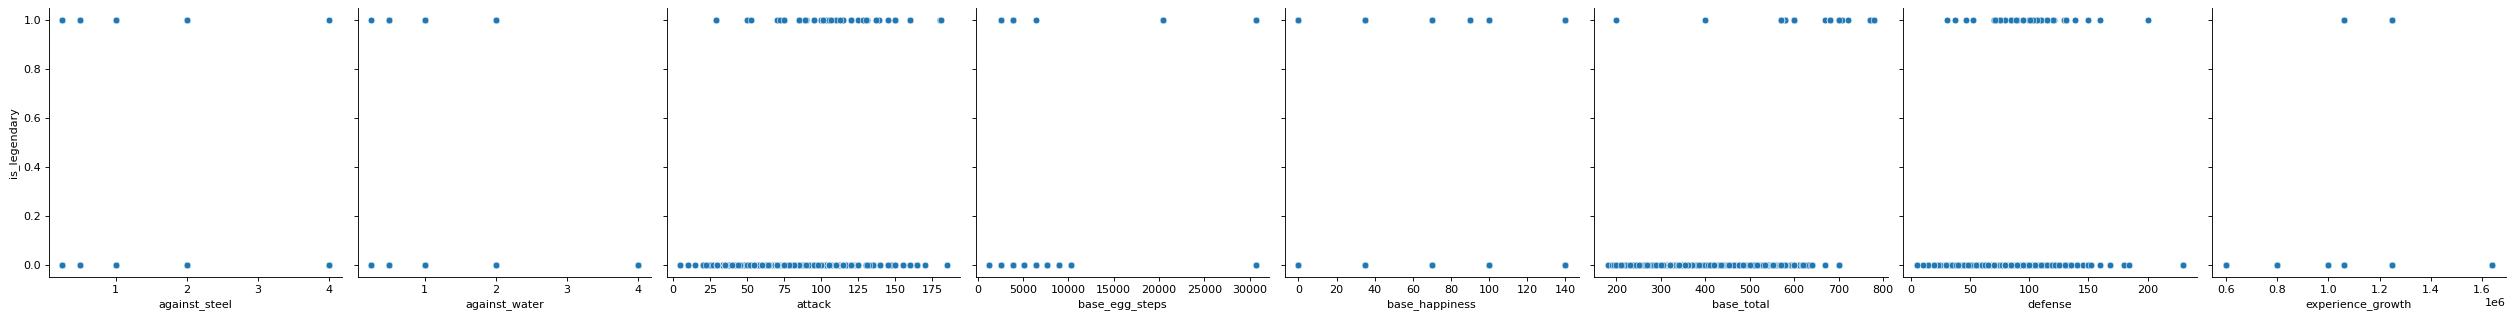

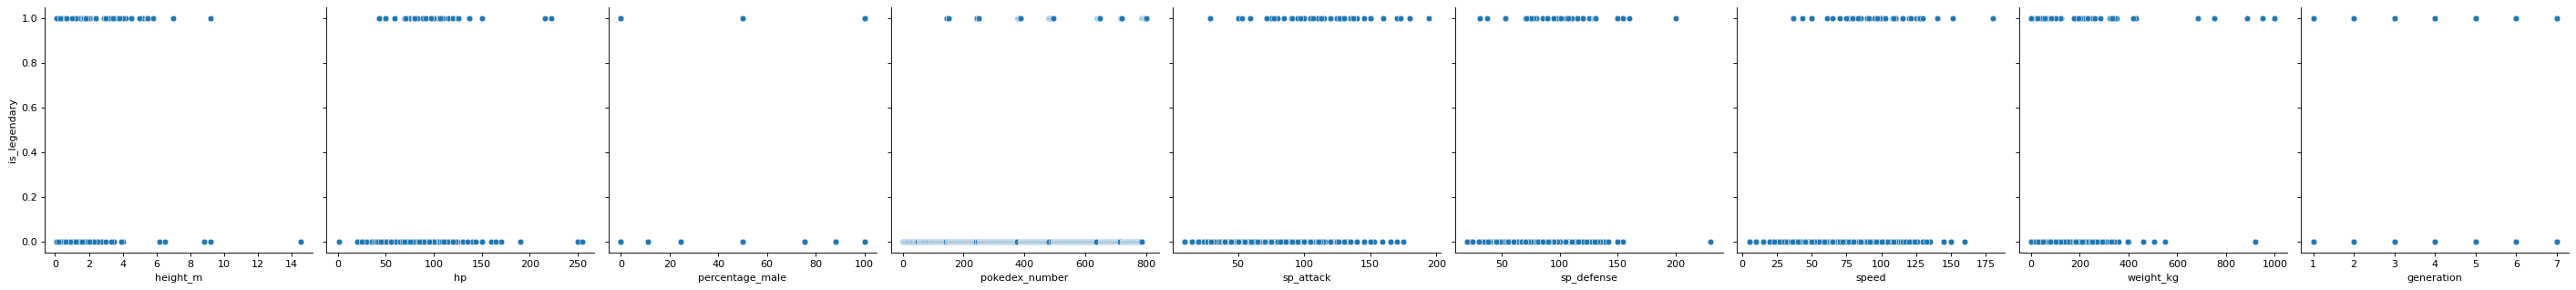

In [112]:
numeric_columns = df.select_dtypes(include='number').columns.drop('is_legendary')

chunk_size = len(numeric_columns) // 4
chunk1 = numeric_columns[:chunk_size]
chunk2 = numeric_columns[chunk_size:chunk_size * 2]
chunk3 = numeric_columns[chunk_size * 2:chunk_size * 3]
chunk4 = numeric_columns[chunk_size * 3:]

sns.pairplot(df, y_vars=['is_legendary'], x_vars=chunk1, dropna=True, height=4)
sns.pairplot(df, y_vars=['is_legendary'], x_vars=chunk2, dropna=True, height=4)
sns.pairplot(df, y_vars=['is_legendary'], x_vars=chunk3, dropna=True, height=4)
sns.pairplot(df, y_vars=['is_legendary'], x_vars=chunk4, dropna=True, height=4)


There seems to be no correlation between the (numeric) variables. Let's do a heatmap to check it out.

<Axes: >

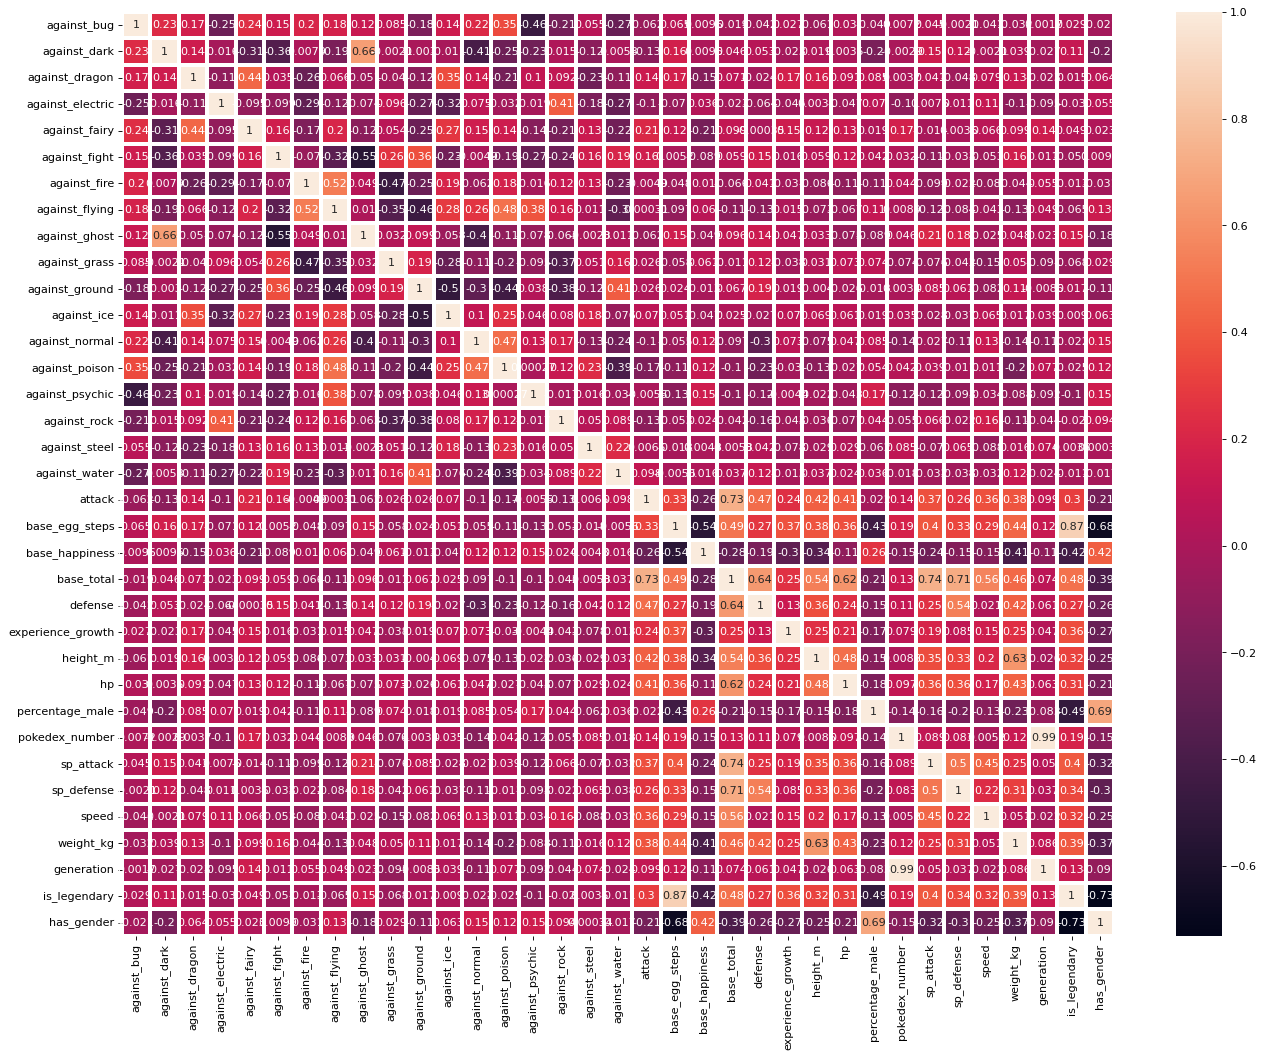

In [113]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(numeric_only=True),annot=True,linewidths=2)

Here we see many correlations. Looking at our target, we see we have a 0.87 correlation with 'base_egg_steps', and a 0.49 correlation with 'base_total' (among others). Additionally, we can see that all the correlations with the 'against_X' variables are very low, so these columns should not be important in our model.

Looking at our heatmap, which should include all of the numeric variables, we can see that there is a numerical column missing ('capture_rate'). Let's see why:

In [114]:
col = 'capture_rate'
def showUniqueValues(col):
    if df[col].dtype == 'object':
        print(f"'{col}' is Categorical")
    else:
        print(f"'{col}' is Continuous")

showUniqueValues(col)

'capture_rate' is Categorical


Let's look at all the unique values that we have in this column to see where's the problem.

In [115]:
print(df['capture_rate'].unique())

['45' '255' '120' '90' '190' '235' '150' '25' '170' '50' '75' '200' '100'
 '180' '60' '225' '30' '35' '3' '65' '70' '127' '125' '205' '155' '145'
 '130' '140' '15' '220' '160' '80' '55' '30 (Meteorite)255 (Core)']


We have a Pokémon that has a variable capture rate depending on its form! To solve this issue, we will "split" this Pokémon in two, creating a row for each form. 

In [116]:
#this only happens once, so we can fix it manually
for index, row in df[df['capture_rate'].str.contains(r'\(')].iterrows():
    new_row1 = row.copy()
    new_row2 = row.copy()
    
    df = df.drop(index)

    new_row1['capture_rate'] = 30
    new_row1['name'] = row['name'] + ' (Meteorite)'

    new_row2['capture_rate'] = 255
    new_row2['name'] = row['name'] + ' (Core)'

    df = pd.concat([df, pd.DataFrame([new_row1, new_row2])], ignore_index=True)

df['capture_rate'] = df['capture_rate'].astype(int)

print(df['capture_rate'].unique())

minior_rows = df[df['name'].str.contains('Minior', na=False)]
print(minior_rows.shape)
print(df.tail(2)['capture_rate'])


[ 45 255 120  90 190 235 150  25 170  50  75 200 100 180  60 225  30  35
   3  65  70 127 125 205 155 145 130 140  15 220 160  80  55]
(2, 42)
780     30
781    255
Name: capture_rate, dtype: int32


In [117]:
showUniqueValues(col)

'capture_rate' is Continuous


Problem fixed! Now we can repeat the correlation matrix to see if there is any correlation between this variable and the target.

<Axes: >

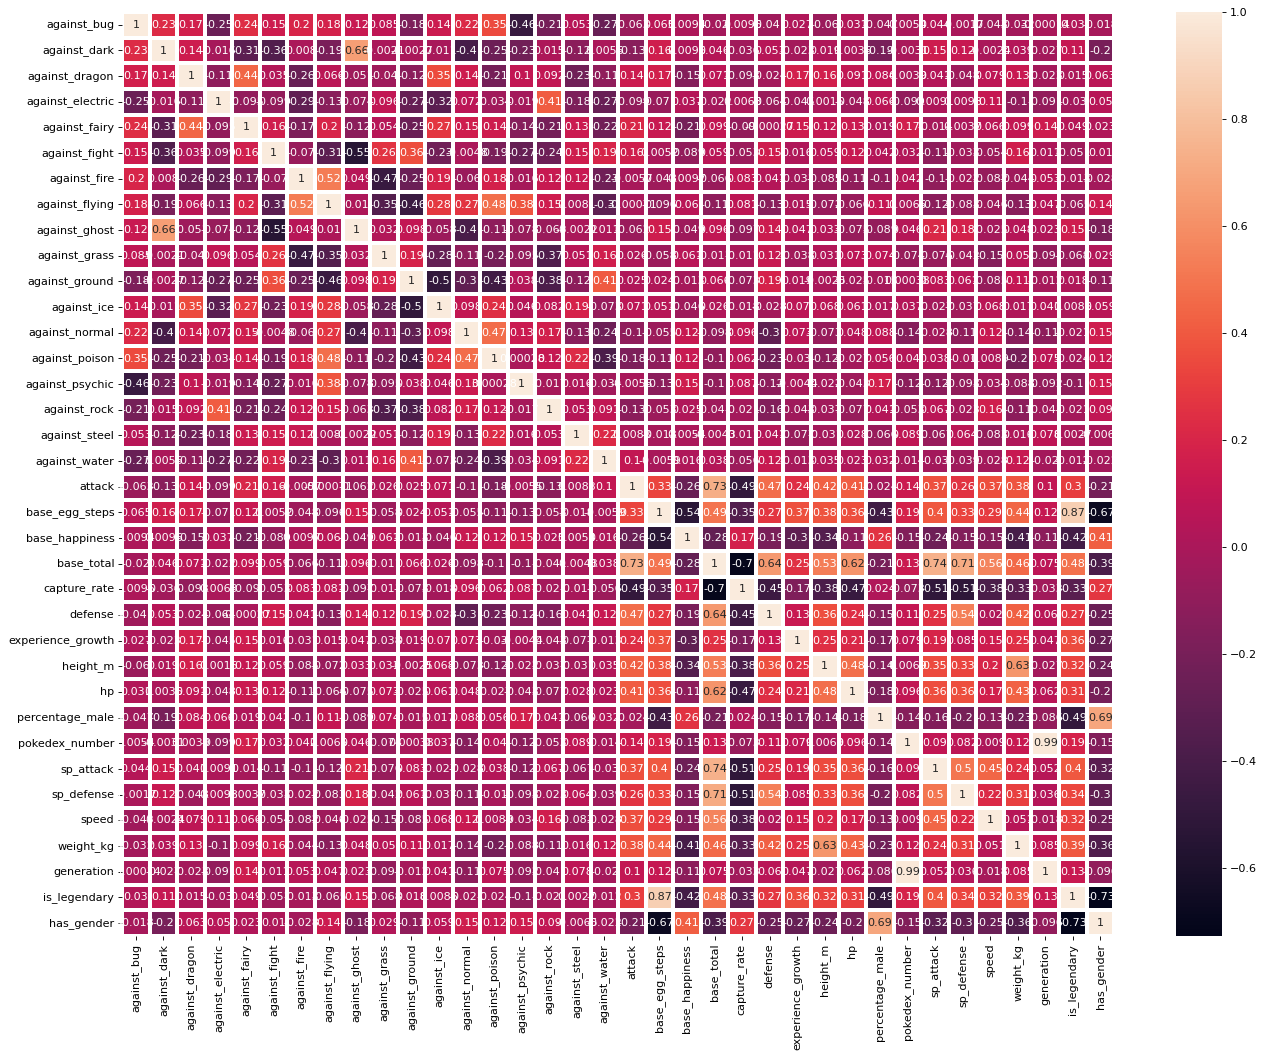

In [118]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(numeric_only=True),annot=True,linewidths=2)

Now that we have fixed our NaNs, we need to encode and normalize our dataset because we have numerical and categorical variables, and there are some variables that have more weight than others. To do so, we will use the OrdinalEncoder and the MinMaxScaler.

### ***ENCODING***:

In [119]:
y = df["is_legendary"]
X = df.drop("is_legendary", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = X_train.select_dtypes(include=["object", "category"]).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[categorical_columns])
X_train[categorical_columns] = encoder.transform(X_train[categorical_columns])
X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])

### ***NORMALIZATION***:

In [120]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train['is_legendary'] = y_train.values

X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test['is_legendary'] = y_test.values


Next, we will do a feature selection because we have many variables that might not be important for our model. To do so, we will use a ***Lasso regression***, which will select the most important features based on the L1 norm of the coefficients.

### ***FEATURE SELECTION***:

In [ ]:
lasso = Lasso(alpha=0.001, random_state=42)
lasso.fit(X_train.drop("is_legendary", axis=1), y_train)

selector = SelectFromModel(lasso, prefit=True)

X_train_selected = selector.transform(X_train.drop("is_legendary", axis=1))
X_test_selected = selector.transform(X_test.drop("is_legendary", axis=1))

selected_features = X_train.drop("is_legendary", axis=1).columns[selector.get_support()]

X_train = pd.DataFrame(X_train_selected, columns=selected_features)
X_test = pd.DataFrame(X_test_selected, columns=selected_features)



c:\Users\Levon\miniconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Levon\miniconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


<Axes: >

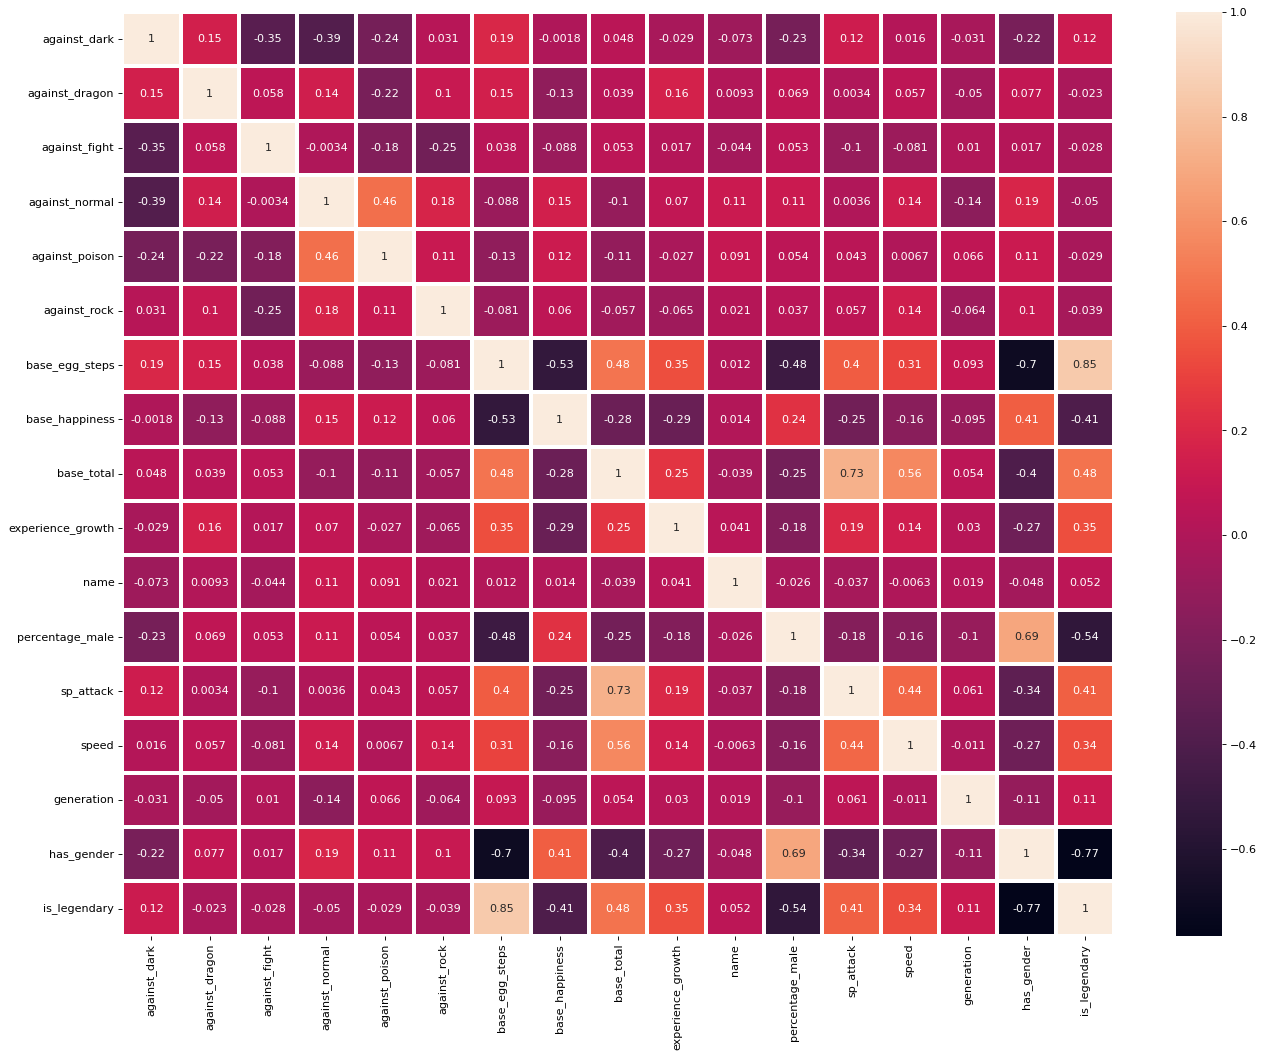

In [122]:
X_train_corr = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
plt.figure(figsize=(20,15))
sns.heatmap(X_train_corr.corr(numeric_only=True),annot=True,linewidths=2)

As we can see, we have reduced our variables a lot, and we still see that 'base_egg_steps' and 'base_total' have a very high correlation with 'is_legendary'. We also see that 'has_gender' has a very high correlation ($-0.77$) with our target too, meaning that this new feature that we have added should be important for our model.

## ***METRIC SELECTION***:

Next, we will decide which metrics we will use to evaluate our model. First, let's define some functions that will be useful:

In [ ]:
def show_metrics(y_test, predictions):
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    avg_prec = average_precision_score(y_test, predictions)

    metriques = ['Accuracy', 'Precision', 'Recall', 'F1', 'Average Precision']
    valors = [acc, prec, rec, f1, avg_prec]

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    bars = ax1.bar(metriques, valors, color=gist_heat_r(valors))
    ax1.set_ylim(0, 1)
    ax1.set_title('Model Metrics')
    ax1.set_xlabel('Metric')
    ax1.set_ylabel('Value')
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval - 0.06, f"{yval:.3f}", ha='center', va='top', color='white')

    conf_mat = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot(ax=ax2)
    ax2.set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

def show_ROC_PR_curves(y_test, probs):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    auc_pr = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_roc = auc(fpr, tpr)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(recall, precision, color='purple')
    ax1.set_title('Precision-Recall Curve')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.annotate(f'AUC PR: {auc_pr:.3f}', xy=(0.5, 0.1), ha='center', xycoords='axes fraction', fontsize=12)

    ax2.plot(fpr, tpr, color='orange')
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.annotate(f'AUC ROC: {auc_roc:.3f}', xy=(0.5, 0.1), ha='center', xycoords='axes fraction', fontsize=12)

    plt.tight_layout()
    plt.show()


def show_PCA(X_test, predictions):
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    pca_result_2d = pca_2d.fit_transform(X_test)
    pca_result_3d = pca_3d.fit_transform(X_test)

    fig = plt.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1)
    scatter_2d = ax1.scatter(pca_result_2d[:, 0], pca_result_2d[:, 1], c=predictions, cmap='viridis', alpha=0.7)
    ax1.set_title('PCA 2D')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    scatter_3d = ax2.scatter(pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2], c=predictions, cmap='viridis', alpha=0.7)
    ax2.set_title('PCA 3D')

    plt.tight_layout()
    plt.show()

To select the adequate metric, let's train a logistic regression model and evaluate it, to see if there are more samples of one class than the other.

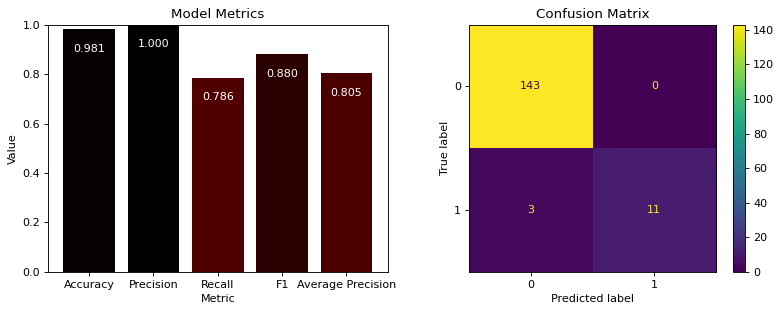

,precision,recall,f1-score,support
0,0.9795,1.0000,0.9896,143.0000
1,1.0000,0.7857,0.8800,14.0000
accuracy,0.9809,0.9809,0.9809,0.9809
macro avg,0.9897,0.8929,0.9348,157.0000
weighted avg,0.9813,0.9809,0.9798,157.0000


In [124]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

show_metrics(y_test, predictions)

report = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

As we can see, we have a very disbalanced dataset. This is very important for the metric selection.

#### Selected Metrics to Evaluate Our Model
* **Accuracy**:
    Shows the total percentage of correct predictions, but can be misleading for imbalanced datasets and does not guide improvements as it doesn't provide information on where we are failing.
    
    <span style="color: red;">✗ Metric not selected</span>

* **F1**:
    This metric combines Precision and Recall values. It gives us information on where we are failing. In this problem, we prioritize increasing both equally, so F1 is the best metric to focus on.
    
    <span style="color: green;">✔ Metric selected</span>

* **Average Precision (AP)**:
    This metric summarizes a precision-recall curve, providing insights into precision and how it’s affected by recall. It's a good metric to consider, though we prioritize F1.
    
    <span style="color: green;">✔ Metric selected, but F1 prioritized</span>

Let's see how the samples in the ``X_test`` dataset are distributed in two and three dimensions after applying PCA, as well as the PR and ROC curves.

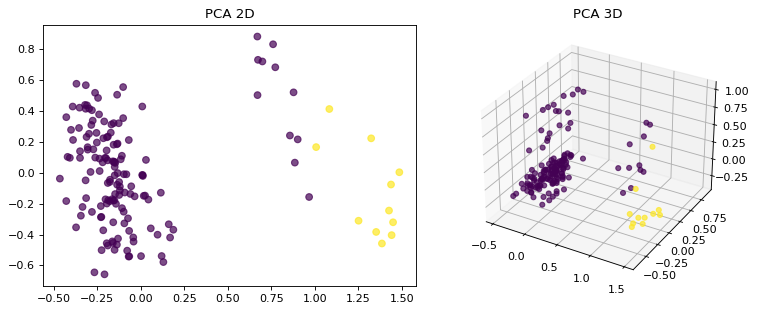

In [125]:
show_PCA(X_test, predictions)

We can see that the PCA shows two clusters, which is what we expected. We can also see that we have some wrong predictions, which makes sense given the scores of the metrics.

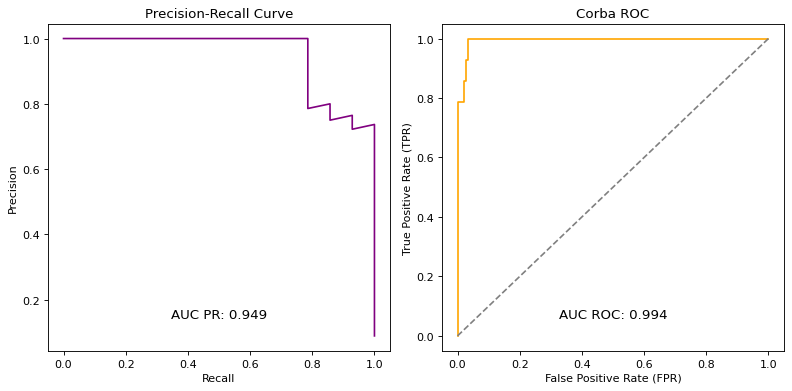

In [126]:
probs = model.predict_proba(X_test)[:, 1]
show_ROC_PR_curves(y_test, probs)

We have a very high AUC in both curves, which is what we expected. However, due to the wrong predictions, the PR curve is not as good as the ROC curve.

## ***MODEL SELECTION WITH CROSS-VALIDATION***

Using Grid Search, we can select the best hyperparameters for our model. We will consider the following classifiers:``LogisticRegresson``, ``KNeighborsClassifier``, ``SVC``, ``DecisionTreeClassifier``, ``RandomForestClassifier``, ``AdaBoostClassifier`` and ``SGDClassifier``. Each one of them will be trained with a different set of hyperparameters, which we will define later.

In [127]:
pipe = Pipeline([('estimator', 'passthrough')])

param_grid = [
    {'estimator': [LogisticRegression()]},
    {'estimator': [SGDClassifier()]},
    {'estimator': [KNeighborsClassifier()]},
    {'estimator': [SVC()]},
    {'estimator': [DecisionTreeClassifier()]},
    {'estimator': [RandomForestClassifier()]},
    {'estimator': [AdaBoostClassifier()]}
]

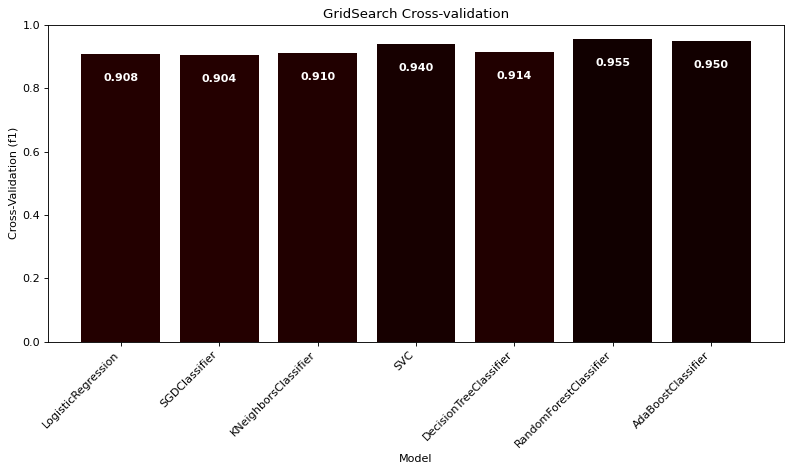

Best Classifier: Pipeline(steps=[('estimator', RandomForestClassifier())])
Best value: 0.9552


In [128]:
repeated_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=repeated_kfold)
grid_search.fit(X_train, y_train)

def show_GridSearchCV(grid_search):
    results = grid_search.cv_results_

    estimator_names = [str(params['estimator']).split('(')[0] for params in results['params']]
    mean_scores = results['mean_test_score']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(estimator_names, mean_scores, color=gist_heat_r(mean_scores))

    plt.ylim(0, 1)
    plt.title('GridSearch Cross-validation')
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation ('+grid_search.scoring+')')

    for bar, _ in zip(bars, mean_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval - 0.06, f"{yval:.3f}", 
                 ha='center', va='top', color='white', fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Best Classifier:", grid_search.best_estimator_)
    print(f"Best value: {grid_search.best_score_:.4f}")


show_GridSearchCV(grid_search)

We can see that we have very high scores for each one of the models. The best classifier, though, is the ``RandomForestClassifier`` with a score of 0.955 which is very close to a perfect classifier. 


Now we will train these classifiers with the best hyperparameters.

To do so, we will use the RandomizedSearchCV, because a GridSearch is too slow and this search produces similar results in much less time.

In [ ]:
repeated_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)

pipe = Pipeline([('estimator', 'passthrough')])

param_distributions = [
    {'estimator': [LogisticRegression()],
     'estimator__C': uniform(0.01, 100)},
    {'estimator': [SGDClassifier()],
     'estimator__alpha': uniform(0.0001, 0.1),
     'estimator__max_iter': randint(500, 5000)},
    {'estimator': [KNeighborsClassifier()],
     'estimator__n_neighbors': randint(1, 15)},
    {'estimator': [SVC()],
     'estimator__C': uniform(0.01, 100),
     'estimator__kernel': ['linear', 'rbf']},
    {'estimator': [DecisionTreeClassifier()],
     'estimator__max_depth': randint(1, 20)},
    {'estimator': [RandomForestClassifier()],
     'estimator__criterion': ['gini', 'entropy', 'log_loss'],
     'estimator__n_estimators': randint(80, 220),
     'estimator__max_depth': randint(1, 20)},
    {'estimator': [AdaBoostClassifier()],
     'estimator__n_estimators': randint(80, 220)}
]

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=100,
    cv=repeated_kfold,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)


In [130]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
                   estimator=Pipeline(steps=[('estimator', 'passthrough')]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'estimator': [LogisticRegression()],
                                         'estimator__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C45D08D040>},
                                        {'estimator': [SGDClassifier...
                                         'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C473DBB370>,
                                         'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C474224040>},
                                        {'estimator': [AdaBoostClassifier()],
                                         'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C4742596D0>}],
                   random_state=42, scoring='f1')

In [131]:
results = search.cv_results_
results_display = pd.DataFrame({
    'Model': [', '.join([f"{key.replace('estimator__', '')}: {value}" for key, value in params.items()]) for params in results['params']],
    'Score': results['mean_test_score'],
    'Temps': results['mean_fit_time'] 
})

pd.set_option('display.max_colwidth', None)
results_display = results_display.sort_values(by='Score', ascending=False).reset_index(drop=True)
results_display

,Model,Score,Temps
0,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: log_loss, max_depth: 9, n_estimators: 141",0.9607,0.4521
1,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: entropy, max_depth: 11, n_estimators: 176",0.9581,0.5306
2,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: gini, max_depth: 6, n_estimators: 107",0.9574,0.3497
3,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: entropy, max_depth: 11, n_estimators: 207",0.9554,0.6848
4,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: gini, max_depth: 17, n_estimators: 141",0.9543,0.4340
...,...,...,...
95,"estimator: SGDClassifier(), alpha: 0.05319345833171364, max_iter: 3277",0.8796,0.0059
96,"estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: gini, max_depth: 1, n_estimators: 200",0.8780,0.5912
97,"estimator: SGDClassifier(), alpha: 0.05257564316322379, max_iter: 3404",0.8779,0.0045
98,"estimator: SGDClassifier(), alpha: 0.0685233026512157, max_iter: 1978",0.8470,0.0046


In [132]:
print("Best classifier:", results_display["Model"][0])
print(f"Best score: {search.best_score_:.4f}")

Best classifier: estimator: RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=141), criterion: log_loss, max_depth: 9, n_estimators: 141
Best score: 0.9607


Our best classifier is:

#### **Random Forest**

| Parameter      | Value       |
|----------------|-------------|
| max_depth      | 9           |
| criterion      | log_loss    |
| n_estimators   | 141         |

## ***FINAL MODEL***

Now that we know the best classifier with its hyperparameters, we can analyze the final model. To obtain the same results, we will fix the random state of the model.

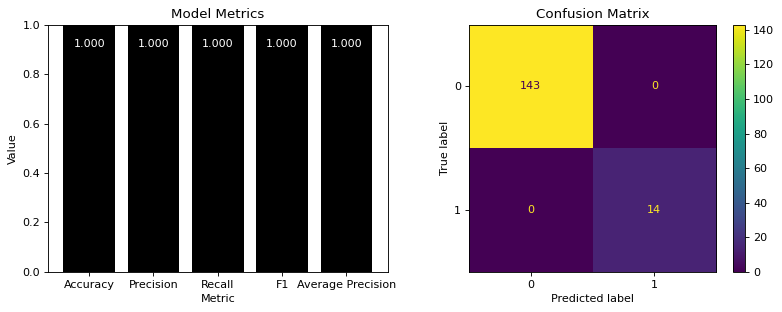

,precision,recall,f1-score,support
0,1.0000,1.0000,1.0000,143.0000
1,1.0000,1.0000,1.0000,14.0000
accuracy,1.0000,1.0000,1.0000,1.0000
macro avg,1.0000,1.0000,1.0000,157.0000
weighted avg,1.0000,1.0000,1.0000,157.0000


In [133]:
model = RandomForestClassifier(criterion= 'log_loss', max_depth= 9, n_estimators= 141, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

show_metrics(y_test, predictions)

report = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

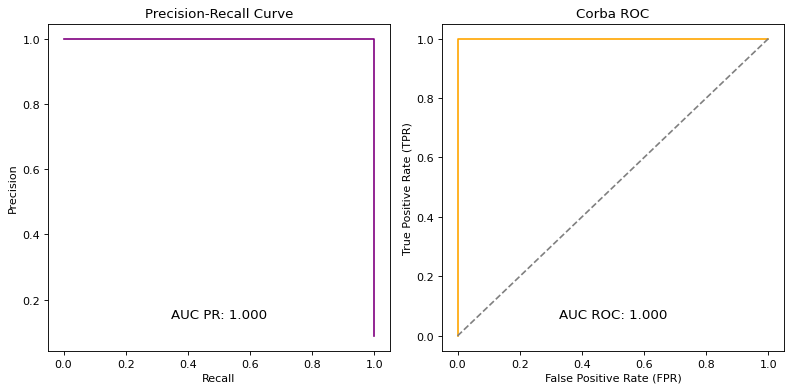

In [134]:
probs = model.predict_proba(X_test)[:, 1]

show_ROC_PR_curves(y_test, probs)

### ***Results***:

Our final model has a score of $1.0$ in all metrics, which is the highest possible score! This doesn't mean that our model is perfect: we have classified perfectly all of our test samples, but during the model selection we have seen that, even though the classifiers worked really well, they were not perfect. We can conclude that our model is close to being perfect.

* Metrics:
    We have achieved a ***perfect*** score in all metrics!

* Curves:
    We have obtained perfect curves in both ROC and PR curves! Their AUCs are $1.0$.

### ***Conclusion***:

With this dataset, which contains data of all the Pokémon from the first 7 generations, we have achieved a "perfect" model. We have been able to classify perfectly each one of our *test samples*, which means our model works very well. To see if this model is perfect, we could add all the missing Pokémon from the newer generations and see the results. This means, with more data, we could see if the model is actually perfect, or if it just works very well.

It is also important to emphasize why this model works so well. Firstly, we haven't got many samples (≈800). Secondly, we have a very high correlation between our target and two of our variables: ***base_egg_steps*** ($0.85$) and ***has_gender*** ($-0.77$), which **wasn't** originally in the dataset. These two reasons could explain the great performance of the model.

### ***Usage of the dataset***:

I used this dataset to predict whether a Pokémon is legendary or not given its characteristics. This is just one of many things we could try to do:

* Which is the strongest Pokémon, based on its base stats, its type, etc.?
* What is the correlation between legendary Pokémons and their type? Are legendary Pokémons more likely to have one type than another?
* Which type is the strongest overall? And which is the weakest?
* Is there any way to do a ranking of every Pokémon based on their utility in the game?
* Is there any generation of Pokémon that is better than any other or do they all have similar strength?
* ...

I would've liked to answer some of these questions, but given the short amount of time I had I couldn't add them to my Kaggle project. 

Anyway, I hope you enjoyed this project and found it interesting!